# Alpha-Seq with Sporulation Simulation

Eric Klavins

Copyright &copy; 2019, University of Washington

# Imports

In [1]:
import numpy as np
import scipy.integrate as spi
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from numpy.random import rand, random
from sympy import *
from sympy.physics.quantum import TensorProduct

%matplotlib inline

# Modeling Yeast Mating

Notation
---

In the a$\alpha$ system, we express proteins $p_1 ... p_n$ on the surface of $a$ variants with concentrations $a_1 ... a_n$. Similarly, we express proteins $q_1 ... q_n$ on the surface of $\alpha$ variants with concentrations $\alpha_1 ... \alpha_n$. We denote the concentration of diploids expressing $p_i$ and $q_j$ by $d_{i,j}$.

Let $M \in \mathbb{P}^{n \times n}$ be a non-negative $n \times n$ matrix of affinities with $M_{i,j}$ denoting the affinity of protein $p_i$ for protein $p_j$ or, equivalently, the rate at which $a_i$ and $\alpha_j$ form diploids $d_{i,j}$ according to the reaction

$$
a_i + \alpha_j \rightarrow d_{i,j}.
$$

The rate at which the above reaction proceeds is thus $M_{i,j}a_i\alpha_j$. 

In the simulations below, we assume that the $M_{i,j}$ are i.i.d. according to an exponential distribution. That is, relatively few interactions have high rates. 

ODEs for $a$ and $\alpha$
---

To determine the equations governing the mating process, we first examine a particular $a_i$, which will be mating with all the other $\alpha_j$ cells and thus decaying at the rate

$$
\dot a_i = - a_i \sum_{j=1}^n M_{i,j}\alpha_j
$$

We collect all of the concentrations into vectors $a$ and $\alpha$. Then, 

$$
\dot a= -\mathrm{diag}(a) M \alpha
$$

Where $\mathrm{diag}(a)$ is the matrix with $a$ on its diagonal and zeros elsewhere. Similarly, 

$$
\dot \alpha = -\mathrm{diag}(\alpha) M^T a
$$

ODE for diploids $d$
---

Now, collect all diploids $d_{i,j}$ into the matrix $d \in \mathbb{P}^{n \times n}$. Then

$$
\dot d = (a \alpha^T) \circ M
$$

where $\circ$ is the Hadamard (element wise) product.

Sporulation
---

After the mating process has completed (or gone on long enough), we collect the diploids and sporulate them. Examining a particular protein $p_i$, we see that it is encoded within all diploids $d_{i,j}$ for $j=1 ... n$. Therefore, after sporulating, we should expect that the concentration of $a_i$ is

$$
\sum_{j=1}^n d_{i,j}
$$

Collecting these quantities into a linear algebra equation, and doing the same for $\alpha$ we get

\begin{align}
a_\mathrm{new} & = d \mathbb{1} \\
\alpha_\mathrm{new} & = d^T \mathbb{1}
\end{align}

where $\mathbb{1}$ is the $n \times 1$ vector of ones. 

Multiple Rounds
---

To simulate multiple rounds of mating and sporulation, we proceed as follows:

- Initialize 
\begin{align}
a(0) & \leftarrow \mathbb{1}/n \\
\alpha(0) & \leftarrow \mathbb{1}/n  \\
d(0) & \leftarrow \mathbb{0}
\end{align}

Then,

1. Simulate the ODEs 
\begin{align}
\dot a & = -\mathrm{diag}(a) M \alpha \\
\dot \alpha & = -\mathrm{diag}(\alpha) M^T a \\
\dot d & = (a \alpha^T) \circ M
\end{align}
for $t$ time units.
2. Set
\begin{align}
a(t+\delta) & \leftarrow \frac{d(t) \mathbb{1}}{|d \mathbb{1}|} \\
\alpha(t+\delta) & \leftarrow \frac{d(t)^T \mathbb{1}}{|d \mathbb{1}|} \\
d(t+\delta) & \leftarrow \mathbb{0}
\end{align} 

3. Goto 1

In [2]:
#
# ODEs encoded in Python
# 
# Here, the first n elements of x represent a, the second
# n elements represent alpha, and the remaining n**2 elements
# represent d. Therefore, x is a 2*n + n**2 dimensional vector.
#
# Before calling this function, make sure to define a global
# m with dimension nxn. 
#
# Note the use of 
#
#  - np.diag to make a vector into a diagonal matrix
#  - np.matmul to do matrix multiplication
#  - np.outer to compute the outer product
#  - np.multiply to do elementwise multiplication (Hadamard product)
#
# This code assumes that x is a numpy array, not just a list.
#
def f(x,t):
    n = sqrt(len(x) + 1) - 1
    a = x[0:n]
    alpha = x[n:2*n]
    return np.concatenate((
        -np.matmul(np.matmul(np.diag(a),m),alpha), 
        -np.matmul(np.matmul(np.diag(alpha),m.transpose()),a), 
        np.multiply(m,np.outer(a,alpha)).flatten()
    ))

# Simulate One Round

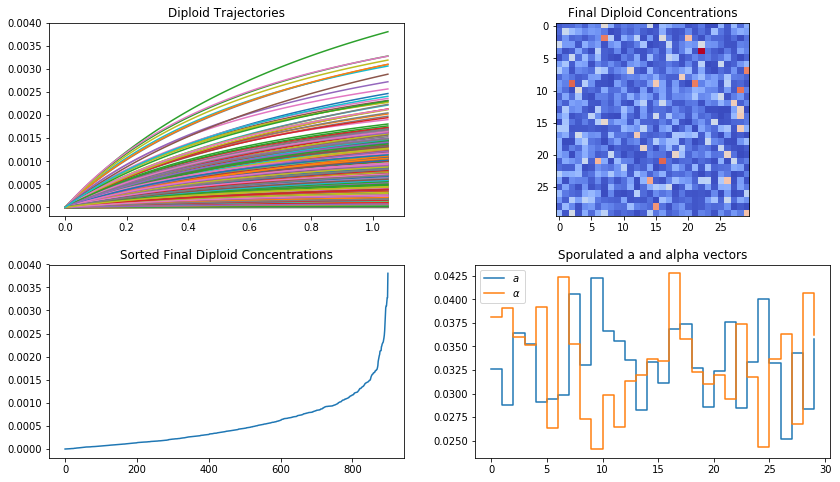

In [3]:
# Set the size of the system
n = 30

# Define the rate matrix
m = np.random.exponential(1,size=(n,n))

# Simulate the system
t = np.linspace(0,1.05,100)
x0 = np.concatenate((np.ones(2*n)/n,np.zeros(n**2)))
x = spi.odeint(f,x0,t)

# Extract diploids from last point in simulation
dips = x[-1][2*n:2*n+n**2].reshape(n,n)

# Make a plot 
fig, ax = plt.subplots(2,2, figsize=(14, 8));

# Plot diplod trajectories
ax[0,0].set_title("Diploid Trajectories");
for i in range(n**2):
    ax[0,0].plot(t,x[:,2*n+i]);

# Plot final diploid concentrations 
ax[0,1].set_title("Final Diploid Concentrations");
ax[0,1].imshow(dips,cmap='coolwarm');

# Plot sorted diploid concentrations
ax[1,0].set_title("Sorted Final Diploid Concentrations");
ax[1,0].plot(np.sort(dips.flatten()))

# Determine sporulated a and alpha concentrations
one = np.ones(n)
a_new     = np.matmul(dips,one)
alpha_new = np.matmul(one.transpose(),dips)
a_new = a_new/sum(a_new)
alpha_new = alpha_new/sum(alpha_new)

# Plot sporulated a and alpha concentrations
ax[1,1].set_title("Sporulated a and alpha vectors")
ax[1,1].plot(a_new,drawstyle="steps-post",label="$a$")
ax[1,1].plot(alpha_new,drawstyle="steps-post",label="$\\alpha$");
ax[1,1].legend()
plt.subplots_adjust(hspace=0.25);

# Simulate Multiple Rounds

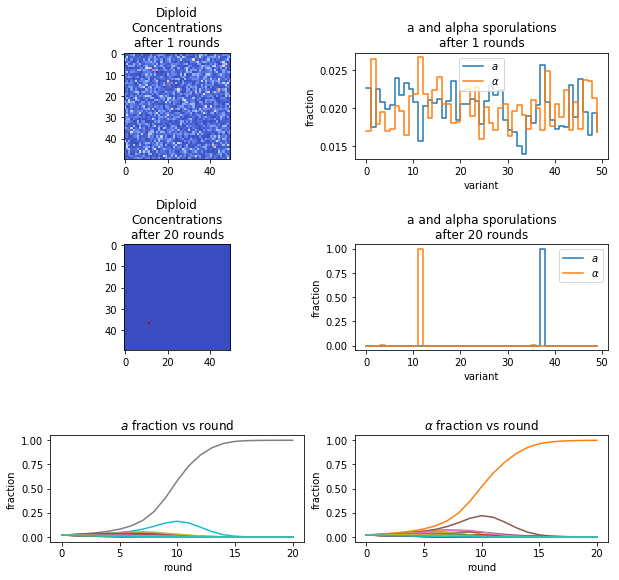

In [4]:
# Number of as and alphas
n = 50

# Rate matrix
m = np.random.exponential(1,size=(n,n))

# Number of iterations
K=20

# Mating duraation
tmax = 0.1

# Simulation setup
t = np.linspace(0,tmax,10)
one = np.ones(n)
x0 = np.concatenate((one/n,one/n,np.zeros(n**2)))
    
# Figure    
fig, ax = plt.subplots(3,2, figsize=(10, 9));

# Data arrays for keeping track of a and alpha
# after each round
a_data = np.array ( [ np.ones(n)/n ] )
alpha_data = np.array ( [ np.ones(n)/n ] )

for i in range(K):

    # Simulate
    x = spi.odeint(f,x0,t)
    dips = x[-1][2*n:2*n+n**2].reshape(n,n)
    
    # Get sporulated vectors
    a_new     = np.matmul(dips,one)
    alpha_new = np.matmul(one.transpose(),dips)
    a_new = a_new/sum(a_new)
    alpha_new = alpha_new/sum(alpha_new)
    
    # Save to data array
    a_data = np.vstack([a_data,a_new])
    alpha_data = np.vstack([alpha_data,alpha_new])
        
    # Plot initial and final diploid concentrations and
    # a and alpha vectors
    if i == 0 or i == K-1:
        j = i%2
        ax[j,0].imshow(dips,cmap='coolwarm');
        ax[j,0].set_title("Diploid\nConcentrations\nafter %d rounds" % (i+1))   
        ax[j,1].plot(a_new,drawstyle="steps-post",label="$a$")
        ax[j,1].plot(alpha_new,drawstyle="steps-post",label="$\\alpha$");
        ax[j,1].set_title("a and alpha sporulations\nafter %d rounds" % (i+1))      
        ax[j,1].set_xlabel("variant")
        ax[j,1].set_ylabel("fraction")        

    # Define x0 for next round
    x0 = np.concatenate((a_new, alpha_new ,np.zeros(n**2)))
    
# Plot data showing change in concentration of as and alphas per round
ax[2,0].plot(a_data);
ax[2,0].set_xlabel("round")
ax[2,0].set_ylabel("fraction")
ax[2,0].set_title("$a$ fraction vs round");
ax[2,1].plot(alpha_data);
ax[2,1].set_xlabel("round")
ax[2,1].set_ylabel("fraction")
ax[2,1].set_title("$\\alpha$ fraction vs round");

plt.subplots_adjust(hspace=0.8);   
ax[0,1].legend()
ax[1,1].legend();

# Image Manipulation

Here, the idea is that the affinity between $p_i$ and $q_j$, saved in $M_{i,j}$, would be arranged so that it is the intensity of a pixel in an $n \times n$ gray scale image. 

We're working on looking at post-zygotic barriers that could do things like edge detection and other things that convolution neural networks can do.

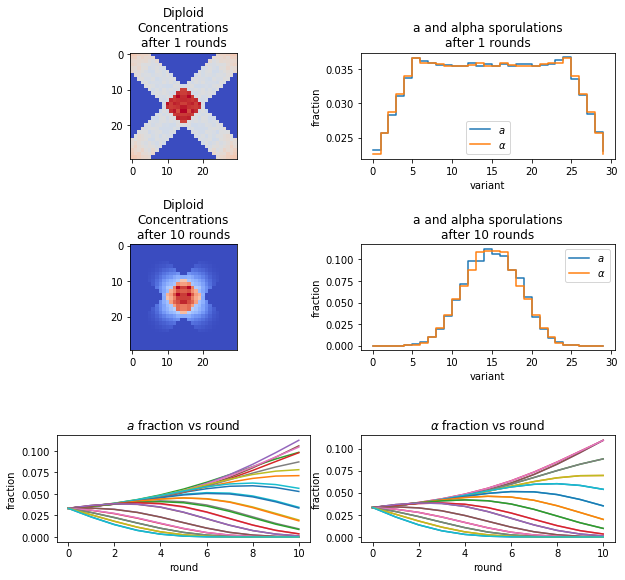

In [5]:
n = 30

m = np.zeros((n,n))
for i in range (n):
  for j in range(11):
    if i+j-5 >= 0 and i+j-5 < 30:
        m[i,i+j-5] = 10 - np.random.random()

m = m + np.flip(m,axis=1)
        
# plt.imshow(m,cmap='coolwarm');

# Number of iterations
K=10

# Mating duraation
tmax = 0.1

# Simulation setup
t = np.linspace(0,tmax,10)
one = np.ones(n)
x0 = np.concatenate((one/n,one/n,np.zeros(n**2)))
    
# Figure    
fig, ax = plt.subplots(3,2, figsize=(10, 9));

# Data arrays for keeping track of a and alpha
# after each round
a_data = np.array ( [ np.ones(n)/n ] )
alpha_data = np.array ( [ np.ones(n)/n ] )

for i in range(K):

    # Simulate
    x = spi.odeint(f,x0,t)
    dips = x[-1][2*n:2*n+n**2].reshape(n,n)
    
    # Get sporulated vectors
    a_new     = np.matmul(dips,one)
    alpha_new = np.matmul(one.transpose(),dips)
    a_new = a_new/sum(a_new)
    alpha_new = alpha_new/sum(alpha_new)
    
    # Save to data array
    a_data = np.vstack([a_data,a_new])
    alpha_data = np.vstack([alpha_data,alpha_new])
        
    # Plot initial and final diploid concentrations and
    # a and alpha vectors
    if i == 0 or i == K-1:
        j = i%2
        ax[j,0].imshow(dips,cmap='coolwarm');
        ax[j,0].set_title("Diploid\nConcentrations\nafter %d rounds" % (i+1))   
        ax[j,1].plot(a_new,drawstyle="steps-post",label="$a$")
        ax[j,1].plot(alpha_new,drawstyle="steps-post",label="$\\alpha$");
        ax[j,1].set_title("a and alpha sporulations\nafter %d rounds" % (i+1))      
        ax[j,1].set_xlabel("variant")
        ax[j,1].set_ylabel("fraction")        

    # Define x0 for next round
    x0 = np.concatenate((a_new, alpha_new ,np.zeros(n**2)))
    
# Plot data showing change in concentration of as and alphas per round
ax[2,0].plot(a_data);
ax[2,0].set_xlabel("round")
ax[2,0].set_ylabel("fraction")
ax[2,0].set_title("$a$ fraction vs round");
ax[2,1].plot(alpha_data);
ax[2,1].set_xlabel("round")
ax[2,1].set_ylabel("fraction")
ax[2,1].set_title("$\\alpha$ fraction vs round");

plt.subplots_adjust(hspace=0.8);   
ax[0,1].legend()
ax[1,1].legend();

# Post Zygotic Barriers

The above equations are unrealistic do not capture the fact that the cells grow and divide during the mating reaction. However, if we assume they all grow at the same rate, then the equations accurately capture the rate of change of the the percentage of each cell type. However, if the cells grow at different rates, we need to add those rates in. More importantly, growth rate becomes an important factor in whether the cells survive to the next round. If, for example, the growth rate of $d_{i,j}$ were zero, it would not matter how high an affinity $p_i$ and $q_j$ had for each other.

To that end, suppose that cells $a_i$ and $\alpha_j$ are engineered to so that they form diploids at a rate $M_{i,j}$ and that the resulting diploids grow at a rate $\gamma_{i,j}$. In this case we  have the equations

\begin{align}
\dot a & = k a - \mathrm{diag}(a) M \alpha \\
\dot \alpha &  = k \alpha - \mathrm{diag}(\alpha) M^T a \\
\dot d & = (a \alpha^T) \circ M + \gamma \circ d
\end{align}

where we have assumed that the $a$ and $\alpha$ cells grow at the same rate $k$. 

One possible way to get interesting might be to assume there are three types of protein: R, P, and S with 

| |    R |  P |  S |
|------|-----|-----|
| R  |  0 |   2 |  -2 | 
| P |  -2 |   0 |   2 |
| S |   2|   -2 |   0 |


In [6]:
def gm(kernel, n):
    K = len(kernel)
    m = int(n / K)
    g = np.zeros((n,n))
    for i in range(K):
        for j in range(K):
            for k in range(m):
                for l in range(m):
                    g[k+m*i,l+m*j] = kernel[i,j]
    return g

gm(np.array([[1,2],[3,4]]),10)

array([[1., 1., 1., 1., 1., 2., 2., 2., 2., 2.],
       [1., 1., 1., 1., 1., 2., 2., 2., 2., 2.],
       [1., 1., 1., 1., 1., 2., 2., 2., 2., 2.],
       [1., 1., 1., 1., 1., 2., 2., 2., 2., 2.],
       [1., 1., 1., 1., 1., 2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3., 4., 4., 4., 4., 4.],
       [3., 3., 3., 3., 3., 4., 4., 4., 4., 4.],
       [3., 3., 3., 3., 3., 4., 4., 4., 4., 4.],
       [3., 3., 3., 3., 3., 4., 4., 4., 4., 4.],
       [3., 3., 3., 3., 3., 4., 4., 4., 4., 4.]])

In [7]:
#
# ODEs with growth rates
# 
def f_growth(x,t):
    n = sqrt(len(x) + 1) - 1
    a = x[0:n]
    alpha = x[n:2*n]
    d = x[2*n:2*n+n**2]
    return np.concatenate((
        k*a-np.matmul(np.matmul(np.diag(a),m),alpha), 
        k*alpha-np.matmul(np.matmul(np.diag(alpha),m.transpose()),a), 
        np.multiply(m,np.outer(a,alpha)).flatten() + np.multiply(gamma.flatten(),d)
    ))
    

In [9]:
n=2
k=1
one = np.ones(n)
m = np.random.exponential(1,size=(n,n))
gamma = np.random.exponential(1,size=(n,n))
x0 = np.concatenate((one/n,one/n,np.zeros(n**2)))
f_growth(x0,0)

array([0.26908005, 0.4109856 , 0.27720261, 0.40286305, 0.21719314,
       0.0137268 , 0.00560425, 0.08341015])

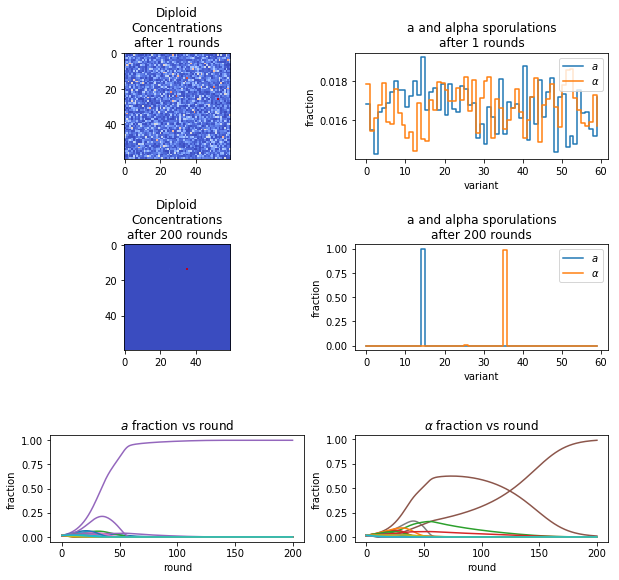

In [36]:
# Number of as and alphas
n = 60

# Rate matrix
# m = np.random.exponential(1,size=(n,n))
# Diploid growth rate matrix
q = np.array([
    [0,2,1],
    [2,2,2],
    [1,2,0]
])
m = np.random.exponential(1,size=(n,n))
# m = np.random.rand(n,n)

# Diploid growth rate matrix
g = np.array([
    [0,2,-2],
    [-2,0,2],
    [2,-2,0]
])
# gamma = 0.2*gm(g,n) + np.random.exponential(.1,size=(n,n))
# gamma = 5*(m + m.transpose())
# gamma = -np.linalg.inv(m)
# gamma = -m.transpose()
# gamma = np.random.exponential(.01,size=(n,n))
gamma = np.random.normal(0,0.01,size=(n,n))

# Haploid growth rate
k = 1

# Number of iterations
K=200

# Mating duration
tmax = 1

# Simulation setup
t = np.linspace(0,tmax,10)
one = np.ones(n)
x0 = np.concatenate((one/n,one/n,np.zeros(n**2)))
    
# Figure    
fig, ax = plt.subplots(3,2, figsize=(10, 9));

# Data arrays for keeping track of a and alpha
# after each round
a_data = np.array ( [ np.ones(n)/n ] )
alpha_data = np.array ( [ np.ones(n)/n ] )

for i in range(K):

    # Simulate
    x = spi.odeint(f_growth,x0,t)
    dips = x[-1][2*n:2*n+n**2].reshape(n,n)
    
    # Get sporulated vectors
    a_new     = np.matmul(dips,one)
    alpha_new = np.matmul(one.transpose(),dips)
    a_new = a_new/sum(a_new)
    alpha_new = alpha_new/sum(alpha_new)
    
    # Save to data array
    a_data = np.vstack([a_data,a_new])
    alpha_data = np.vstack([alpha_data,alpha_new])
        
    # Plot initial and final diploid concentrations and
    # a and alpha vectors
    if i == 0 or i == K-1:
        j = i%2
        ax[j,0].imshow(dips,cmap='coolwarm');
        ax[j,0].set_title("Diploid\nConcentrations\nafter %d rounds" % (i+1))   
        ax[j,1].plot(a_new,drawstyle="steps-post",label="$a$")
        ax[j,1].plot(alpha_new,drawstyle="steps-post",label="$\\alpha$");
        ax[j,1].set_title("a and alpha sporulations\nafter %d rounds" % (i+1))      
        ax[j,1].set_xlabel("variant")
        ax[j,1].set_ylabel("fraction")        

    # Define x0 for next round
    x0 = np.concatenate((a_new, alpha_new ,np.zeros(n**2)))
    
# Plot data showing change in concentration of as and alphas per round
ax[2,0].plot(a_data);
ax[2,0].set_xlabel("round")
ax[2,0].set_ylabel("fraction")
ax[2,0].set_title("$a$ fraction vs round");
ax[2,1].plot(alpha_data);
ax[2,1].set_xlabel("round")
ax[2,1].set_ylabel("fraction")
ax[2,1].set_title("$\\alpha$ fraction vs round");

plt.subplots_adjust(hspace=0.8);   
ax[0,1].legend()
ax[1,1].legend();

# Diploid Selection

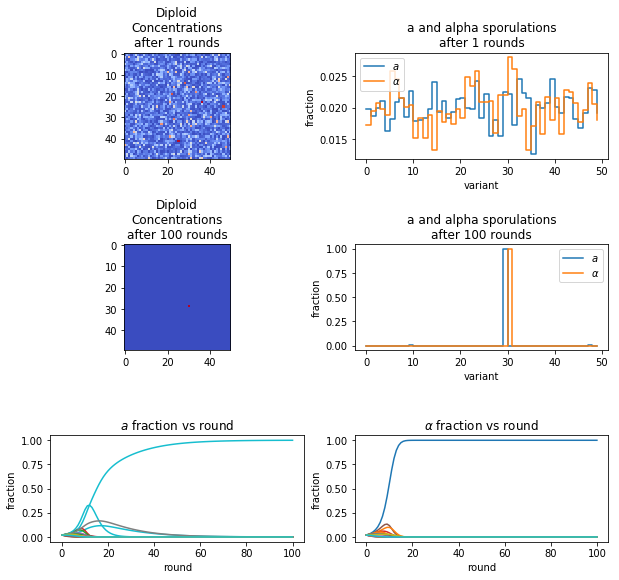

In [106]:
# Number of as and alphas
n = 50

# Rate matrix
m = np.random.exponential(1,size=(n,n))

# Number of iterations
K=100

# Mating duraation
tmax = 0.1

# Simulation setup
t = np.linspace(0,tmax,10)
one = np.ones(n)
x0 = np.concatenate((one/n,one/n,np.zeros(n**2)))
    
# Figure    
fig, ax = plt.subplots(3,2, figsize=(10, 9));

# Data arrays for keeping track of a and alpha
# after each round
a_data = np.array ( [ np.ones(n)/n ] )
alpha_data = np.array ( [ np.ones(n)/n ] )

for i in range(K):

    # Simulate
    x = spi.odeint(f,x0,t)
    dips = x[-1][2*n:2*n+n**2].reshape(n,n)
    
    # Get sporulated vectors
    a_new     = np.matmul(dips,one)
    a_new = a_new/sum(a_new)
    
    # finds the a protein that has the largest sum of affinities
    # alpha_new = one/n 
    
    # finds the a protein sticks to a selected alpha protein the best
    # alpha_new = 0.9 * one/n
    # alpha_new[int(n/2)] += 0.1
        
    alpha_new = np.matmul(one.transpose(),dips)
    alpha_new = alpha_new/sum(alpha_new)
    
    # Save to data array
    a_data = np.vstack([a_data,a_new])
    alpha_data = np.vstack([alpha_data,alpha_new])
        
    # Plot initial and final diploid concentrations and
    # a and alpha vectors
    if i == 0 or i == K-1:
        j = i%2
        ax[j,0].imshow(dips,cmap='coolwarm');
        ax[j,0].set_title("Diploid\nConcentrations\nafter %d rounds" % (i+1))   
        ax[j,1].plot(a_new,drawstyle="steps-post",label="$a$")
        ax[j,1].plot(alpha_new,drawstyle="steps-post",label="$\\alpha$");
        ax[j,1].set_title("a and alpha sporulations\nafter %d rounds" % (i+1))      
        ax[j,1].set_xlabel("variant")
        ax[j,1].set_ylabel("fraction")        

    # Define x0 for next round
    x0 = np.concatenate((a_new, alpha_new ,np.zeros(n**2)))
    
# Plot data showing change in concentration of as and alphas per round
ax[2,0].plot(a_data);
ax[2,0].set_xlabel("round")
ax[2,0].set_ylabel("fraction")
ax[2,0].set_title("$a$ fraction vs round");
ax[2,1].plot(alpha_data);
ax[2,1].set_xlabel("round")
ax[2,1].set_ylabel("fraction")
ax[2,1].set_title("$\\alpha$ fraction vs round");

plt.subplots_adjust(hspace=0.8);
ax[0,1].legend()
ax[1,1].legend();